<a href="https://colab.research.google.com/github/JHWannabe/keras-dl/blob/main/10%EC%9E%A5_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%B0%BD%EC%8B%9C%EC%9E%90%EC%97%90%EA%B2%8C_%EB%B0%B0%EC%9A%B0%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10.2 온도 예측 문제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-08 06:17:20--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.161.112, 52.217.224.136, 52.216.18.219, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.161.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  12.7MB/s    in 1.0s    

2023-02-08 06:17:22 (12.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
# 예나 날씨 데이터셋 조사하기기
import os
fname = os.path.join("jena_climate_2009_2016.csv")  

with open(fname) as f:
    data = f.read()  

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
# 데이터 파싱
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

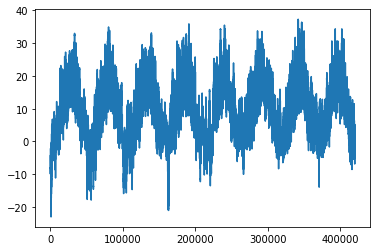

In [4]:
# 전체 온도를 그래프로 그리기
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

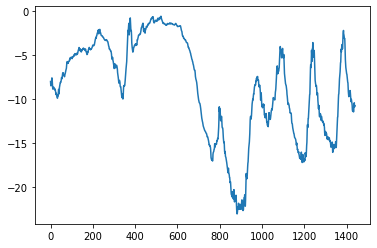

In [5]:
# 처음 100일간의 온도를 그래프로 그리기
plt.plot(range(1440), temperature[:1440])
plt.show()

In [6]:
# 각 분할에 사용할 샘플 개수 계산하기
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 10.2.1 데이터 준비

In [7]:
# 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
# 훈련, 검증, 테스트 데이터셋 만들기
import keras

sampling_rate = 6 
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256   

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)  

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
# 훈련 데이터셋의 배치 크기 확인하기
for samples, targets in train_dataset:
  print("샘플 크기:", samples.shape)
  print("타깃 크기:", targets.shape)
  break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 10.2.2 상식 수준의 기준점

In [11]:
# 상식 수준 모델의 MAE 계산하기
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen  

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 10.2.3 기본적인 머신 러닝 모델 시도해 보기

In [12]:
# 밀집 연결 모델 훈련하고 평가하기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)  

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)  

model = keras.models.load_model("jena_dense.keras")     
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 59s 70ms/step - loss: 14.1722 - mae: 2.8924 - val_loss: 11.6630 - val_mae: 2.6950
Epoch 2/10
819/819 [==============================] - 55s 66ms/step - loss: 9.2688 - mae: 2.3940 - val_loss: 11.2280 - val_mae: 2.6434
Epoch 3/10
819/819 [==============================] - 56s 68ms/step - loss: 8.4900 - mae: 2.2949 - val_loss: 12.0445 - val_mae: 2.7522
Epoch 4/10
819/819 [==============================] - 57s 69ms/step - loss: 7.9837 - mae: 2.2264 - val_loss: 11.4494 - val_mae: 2.6838
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 7.6792 - mae: 2.1853 - val_loss: 11.2874 - val_mae: 2.6563
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 7.4550 - mae: 2.1539 - val_loss: 10.8217 - val_mae: 2.6083
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 7.2315 - mae: 2.1229 - val_loss: 10.6173 - val_mae: 2.5839
Epoch 8/10
819/819 [==============================] - 

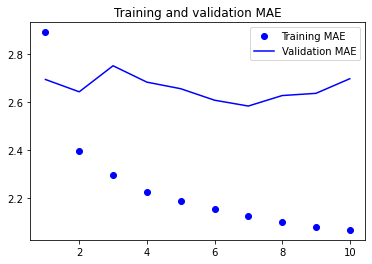

In [13]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.2.4 1D 합성곱 모델 시도해 보기

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)  

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)  

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 74s 89ms/step - loss: 22.5269 - mae: 3.7235 - val_loss: 15.9957 - val_mae: 3.1861
Epoch 2/10
819/819 [==============================] - 73s 88ms/step - loss: 15.8886 - mae: 3.1719 - val_loss: 14.6134 - val_mae: 3.0422
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 14.4475 - mae: 3.0238 - val_loss: 18.1993 - val_mae: 3.3822
Epoch 4/10
819/819 [==============================] - 75s 91ms/step - loss: 13.5011 - mae: 2.9231 - val_loss: 15.2311 - val_mae: 3.0923
Epoch 5/10
819/819 [==============================] - 75s 91ms/step - loss: 12.7890 - mae: 2.8460 - val_loss: 14.9087 - val_mae: 3.0463
Epoch 6/10
819/819 [==============================] - 75s 92ms/step - loss: 12.1843 - mae: 2.7735 - val_loss: 15.1193 - val_mae: 3.0806
Epoch 7/10
819/819 [==============================] - 74s 90ms/step - loss: 11.6964 - mae: 2.7180 - val_loss: 14.1820 - val_mae: 2.9716
Epoch 8/10
819/819 [============================

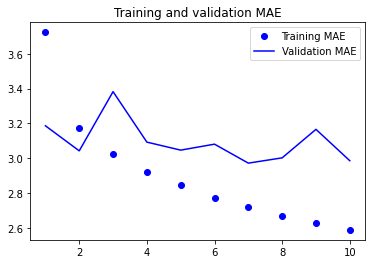

In [15]:
# 결과 그래프 그리기
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.2.5 첫 번째 순환 신경망

In [16]:
# 간단한 LSTM 기반 모델
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
 
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 116ms/step - loss: 44.4307 - mae: 4.8446 - val_loss: 12.9821 - val_mae: 2.7376
Epoch 2/10
819/819 [==============================] - 92s 112ms/step - loss: 11.1772 - mae: 2.6073 - val_loss: 9.6563 - val_mae: 2.4146
Epoch 3/10
819/819 [==============================] - 96s 116ms/step - loss: 9.9150 - mae: 2.4636 - val_loss: 9.4791 - val_mae: 2.4038
Epoch 4/10
819/819 [==============================] - 96s 117ms/step - loss: 9.4097 - mae: 2.3945 - val_loss: 9.3087 - val_mae: 2.3747
Epoch 5/10
819/819 [==============================] - 105s 128ms/step - loss: 9.1049 - mae: 2.3523 - val_loss: 9.5723 - val_mae: 2.3694
Epoch 6/10
819/819 [==============================] - 98s 119ms/step - loss: 8.8368 - mae: 2.3207 - val_loss: 9.2773 - val_mae: 2.3492
Epoch 7/10
819/819 [==============================] - 98s 119ms/step - loss: 8.6359 - mae: 2.2916 - val_loss: 9.0921 - val_mae: 2.3329
Epoch 8/10
819/819 [==============================]

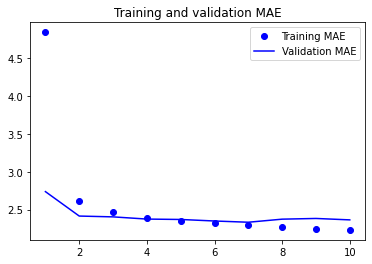

In [17]:
# 결과 그래프 그리기
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.3 순환 신경망 이해하기

### 10.3.1 케라스의 순환 층

In [19]:
# 어떤 길이의 시퀀스도 처리할 수 있는 RNN 층
num_features = 14 
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [21]:
# 마지막 출력 스텝만 반환하는 RNN 층
num_features = 14 
steps = 120 
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [22]:
# 전체 출력 시퀀스를 반환하는 RNN 층
num_features = 14 
steps = 120 
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [23]:
# 스태킹(stacking) RNN 층
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [24]:
# LSTM 구조의 의사 코드(1/2)
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

NameError: ignored

In [ ]:
# LSTM 구조의 의사 코드(2/2)
c_t+1 = i_t * k_t + c_t * f_t

## 10.4 순환 신경망의 고급 사용법

### 10.4.1 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

In [26]:
# 드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 190s 228ms/step - loss: 25.1300 - mae: 3.7260 - val_loss: 9.8117 - val_mae: 2.4317
Epoch 2/50
819/819 [==============================] - 181s 221ms/step - loss: 14.7885 - mae: 2.9833 - val_loss: 9.2686 - val_mae: 2.3571
Epoch 3/50
819/819 [==============================] - 177s 216ms/step - loss: 13.8084 - mae: 2.8805 - val_loss: 9.6820 - val_mae: 2.4136
Epoch 4/50
819/819 [==============================] - 184s 224ms/step - loss: 13.1265 - mae: 2.8067 - val_loss: 9.6932 - val_mae: 2.4185
Epoch 5/50
819/819 [==============================] - 182s 222ms/step - loss: 12.6287 - mae: 2.7552 - val_loss: 9.8925 - val_mae: 2.4485
Epoch 6/50
819/819 [==============================] - 192s 234ms/step - loss: 12.3613 - mae: 2.7238 - val_loss: 9.5102 - val_mae: 2.3996
Epoch 7/50
819/819 [==============================] - 189s 231ms/step - loss: 12.0813 - mae: 2.6911 - val_loss: 9.4904 - val_mae: 2.4067
Epoch 8/50
819/819 [=====================

### 10.4.2 스태킹 순환 층

In [ ]:
# 드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)  

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 291s 349ms/step - loss: 24.9278 - mae: 3.6922 - val_loss: 9.4421 - val_mae: 2.3872
Epoch 2/50
819/819 [==============================] - 286s 349ms/step - loss: 14.0726 - mae: 2.9044 - val_loss: 9.0597 - val_mae: 2.3300
Epoch 3/50
819/819 [==============================] - 288s 352ms/step - loss: 13.2802 - mae: 2.8247 - val_loss: 9.2560 - val_mae: 2.3615
Epoch 4/50
819/819 [==============================] - 290s 353ms/step - loss: 12.5944 - mae: 2.7559 - val_loss: 8.9481 - val_mae: 2.3190
Epoch 5/50
819/819 [==============================] - 298s 364ms/step - loss: 12.1124 - mae: 2.7042 - val_loss: 9.6601 - val_mae: 2.4116
Epoch 6/50
819/819 [==============================] - 293s 357ms/step - loss: 11.6912 - mae: 2.6543 - val_loss: 8.9285 - val_mae: 2.3207
Epoch 7/50
819/819 [==============================] - 289s 353ms/step - loss: 11.2715 - mae: 2.6058 - val_loss: 9.2769 - val_mae: 2.3587
Epoch 8/50
819/819 [=====================

### 10.4.3 양방향 RNN 사용하기

In [ ]:
# 양방향 LSTM 모델 훈련하고 평가하기
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)